In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import os

os.environ["CUDA_VISIBLE_DEVICES"]="2"
print(torch.cuda.is_available())
print(torch.cuda.device_count())

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define latency buckets with finer granularity
def latency_to_bucket(latency):
    return min(int(np.log2(latency) * 2), 29)  # 30 buckets

# Load data
data = pd.read_csv("io_latency.csv")
data.columns = ['sector', 'size', 'op', 'latency_us', 'pending_ios']

# Features and target
X = data[['sector', 'size', 'op', 'pending_ios']].values
y = np.array([latency_to_bucket(latency) for latency in data['latency_us'].values])

# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)  # CrossEntropyLoss expects long dtype for targets
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# Define the neural network model
class LatencyPredictor(nn.Module):
    def __init__(self):
        super(LatencyPredictor, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 30)  # 30 output classes (0 to 29)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create model instance and move it to the device
model = LatencyPredictor().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % (epochs // 10) == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    test_loss = criterion(predictions, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

    # Calculate accuracy
    _, predicted_classes = torch.max(predictions, 1)
    accuracy = (predicted_classes == y_test).float().mean()
    print(f'Accuracy: {accuracy.item():.4f}')

# Save the model
torch.save(model.state_dict(), "latency_predictor.pth")
print("Model saved to latency_predictor.pth")


2024-05-05 19:46:52,184	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-05-05 19:46:52,616	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


64


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [4]:
workloads = ["readseq0", "readseq1", "readseq2", "readseq3", "readwhilewriting0", "readwhilewriting1", "readreverse0", "readrandomwriterandom0", "readrandom0", "mixgraph0", "fillseq0", "fillseq1", "fill100k0", "fill100k1"]
config = {"lr" : 0.01, "momentum" : 0.90}
num_epoch = 50
do_binary_classification = False

In [5]:
experiments = {}
for w in workloads:
    # print("reading data for", w)
    data = np.loadtxt("data/" + w + ".csv",
                      dtype=np.double, skiprows=1, delimiter=",")
    experiments[w] = data

In [6]:
data_all = experiments[workloads[0]]

# duplicate data
for i in range(len(workloads)):
    data_temp = experiments[workloads[i]]
    while len(data_temp) < 160000:
        data_temp = np.concatenate((data_temp, experiments[workloads[i]]), axis=0)
    data_all = np.concatenate((data_all, data_temp), axis=0)

# combine other workloads (but only one time)
# for index, w in enumerate(workloads):
#     if (index == 0):
#         continue
#     print(w)
#     print(data_all.shape)
#     print(experiments[w].shape)
#     data_all = np.concatenate((data_all, experiments[w]), axis=0)

In [17]:
np.shape(data_all)

(2863703, 8)

In [7]:
# split data into input and output
input = data_all[:,0:7]
output = data_all[:,7]

In [9]:
input = np.concatenate((input[:, 1:2], input[:, 4:7]), axis=1)

In [8]:
# get normalized input (output stays unnormalized)
norm_input = stats.zscore(input, axis=0)

print(min(output), max(output))
output = output.reshape(-1, 1)

norm_input, output, input = shuffle(norm_input, output, input)

4.6644e-05 0.591229274


In [20]:
def np_out_csv(ar, name=None):
    if name == None:
        name = "file"
    import pandas as pd
    df = pd.DataFrame(ar)
    df.to_csv(index=False, header=False, sep=" ", path_or_buf=name + ".csv", float_format="%015.6f") #save to file

In [25]:
# convert to one-hot encoding for operation
# data_no_op = np.concatenate((norm_input[:, 0:1], norm_input[:, 2:7]), axis=1)
# data_only_ops = np.zeros((len(data_no_op), 8))
# for i in range(len(data_no_op)):
#     data_only_ops[i,int(input[i,1])] = 1

# norm_input = np.concatenate((data_no_op, data_only_ops), axis=1)


In [12]:
# for i in range(len(input[0])):
#     print(np.mean(input[:,i]))
# for i in range(len(input[0])):
    # print(np.std(input[:,i]))

In [ ]:
'''

training:
    1) normalize
    2) one-hot encoding for operations
    3) multiply outputs by 1e9

latency.c:
    process_new_features:
    1) normalize
    2) make prediction
    completed_request:
    3) add back to prediction how many we subtracted (thus we get the actual prediction class in log2(time))
    4) calculate actual prediction class in log2(time) by taking log of diff
    5) write the prediction and actual

parse.py:
    Just parse the actual data. Don't make any modifications.
'''

/tmp/ipykernel_1519055/765573451.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(int(math.log2(max(bin_output))), max(bin_output), max(output))


29 [5.91229274e+08] [0.59122927]


/tmp/ipykernel_1519055/765573451.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bin_output[idx] = int(math.log2(o))


[15.] [29.]


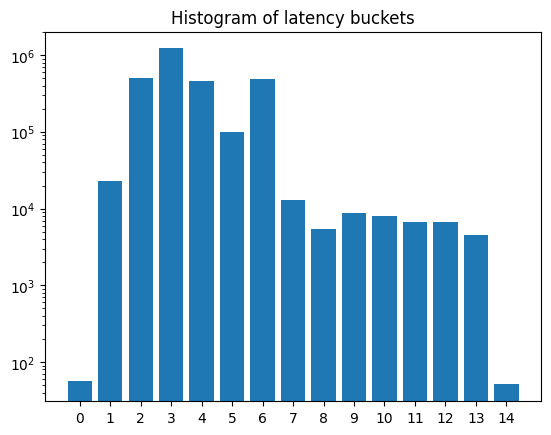

In [9]:
import math
import collections

# convert to nanoseconds
bin_output = output * 1e9

print(int(math.log2(max(bin_output))), max(bin_output), max(output))

for idx, o in enumerate(bin_output):
    bin_output[idx] = int(math.log2(o))

bin_output.reshape(-1, 1)
print(min(bin_output), max(bin_output))
# make minimum 0
# make sure to add this difference back in later
bin_output = bin_output - min(bin_output)

#norm_input, bin_output, (norm_input_sub, bin_output_sub) = equalize_bins(norm_input, bin_output)
cnt = collections.Counter(bin_output.ravel())

bin_list = []
for i in range(32):
    bin_list.append(i)

class_size = max(bin_output) - min(bin_output) + 1
#plt.hist(bin_output, bins=range(0, int(max(cnt.keys())) + 2))
plt.bar(cnt.keys(), cnt.values())
plt.xticks(list(cnt.keys()))
plt.title("Histogram of latency buckets")
plt.yscale("log")
plt.show()

In [22]:
print(norm_input.shape)
print(bin_output.shape)

(2863703, 7)
(2863703, 1)


In [10]:
buckets = [0] * int(class_size)

for index, bo in enumerate(bin_output):
    buckets[int(bo)] = buckets[int(bo)] + 1

print(buckets)
max_bo = max(buckets)

buckets = np.array(buckets, dtype=np.float64)
buckets /= max_bo
buckets = 1.0 / buckets
buckets = buckets.astype(np.int32)

print(buckets)

/tmp/ipykernel_1519055/3464899621.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  buckets = [0] * int(class_size)
/tmp/ipykernel_1519055/3464899621.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  buckets[int(bo)] = buckets[int(bo)] + 1


[57, 23253, 507770, 1226247, 465099, 99223, 489002, 12833, 5488, 8739, 8026, 6662, 6777, 4476, 51]
[21513    52     2     1     2    12     2    95   223   140   152   184
   180   273 24044]


In [11]:
copy_norm_input = []
copy_bin_output = []
copy_input = []

for index, bo in enumerate(bin_output):
    if (buckets[int(bo)] > 1):
        for b in range(buckets[int(bo)] - 1):
            copy_norm_input.append(norm_input[index])
            copy_bin_output.append(bin_output[index])
            copy_input.append(input[index])
    else:
        copy_norm_input.append(norm_input[index])
        copy_bin_output.append(bin_output[index])
        copy_input.append(input[index])

norm_input = np.array(copy_norm_input)
bin_output = np.array(copy_bin_output)
input = np.array(copy_input)

/tmp/ipykernel_1519055/89968733.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if (buckets[int(bo)] > 1):
/tmp/ipykernel_1519055/89968733.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  for b in range(buckets[int(bo)] - 1):


In [12]:
cnt2 = collections.Counter(bin_output.ravel())

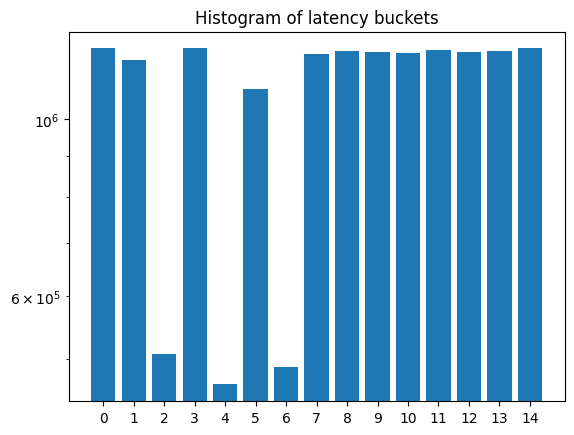

In [13]:
plt.bar(cnt2.keys(), cnt2.values())
plt.xticks(list(cnt.keys()))
plt.title("Histogram of latency buckets")
plt.yscale("log")
plt.show()

In [15]:
# Save old bin output incase we want to change split
old_bin_output = bin_output

In [ ]:
if do_binary_classification:
    bin_output = old_bin_output
    print(np.unique(bin_output))
    split = 4
    bin_output_binary = np.zeros_like(bin_output)
    for index, val in enumerate(bin_output):
        bin_output_binary[index] = int(val > split)
    bin_output = bin_output_binary
    print(np.unique(bin_output))
    percent_high = sum(bin_output)/len(bin_output)
    print(percent_high)
    naive_pred = max(percent_high, 1-percent_high) * 100

In [ ]:
from sklearn.model_selection import train_test_split
input_train, input_test, bin_output_train, bin_output_test = train_test_split(norm_input, bin_output, test_size=0.33, random_state=42)

In [13]:
class latencyPredictor(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(latencyPredictor, self).__init__()
        self.layer_1 = torch.nn.Linear(inputSize, 512)
        self.layer_2 = torch.nn.Linear(512, 128)
        self.layer_3 = torch.nn.Linear(128, 64)
        self.layer_out = torch.nn.Linear(64, outputSize)
        
        self.relu = torch.nn.Sigmoid()
        # self.softmax = torch.nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.relu(x)
        
        x = self.layer_3(x)
        x = self.relu(x)
        
        x = self.layer_out(x)
        # added softmax to turn our results into preds
        # x = self.softmax(x)
        # Nevermind! We don't have access to a Softmax layer!
        return x

In [25]:
# use multiple gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [38]:
# state_dict2 = {}
# state_dict2["module.layer_1.weight"] = state_dict["module.module.layer_1.weight"]
# state_dict2["module.layer_2.weight"] = state_dict["module.module.layer_2.weight"]
# state_dict2["module.layer_3.weight"] = state_dict["module.module.layer_3.weight"]
# state_dict2["module.layer_out.weight"] = state_dict["module.module.layer_out.weight"]
# state_dict2["module.layer_1.bias"] = state_dict["module.module.layer_1.bias"]
# state_dict2["module.layer_2.bias"] = state_dict["module.module.layer_2.bias"]
# state_dict2["module.layer_3.bias"] = state_dict["module.module.layer_3.bias"]
# state_dict2["module.layer_out.bias"] = state_dict["module.module.layer_out.bias"]

In [ ]:
# do this if you want to load a previous model
latencyPred = latencyPredictor(norm_input.shape[1], int(class_size))
latencyPred.double()
latencyPred = torch.nn.DataParallel(latencyPred)
latencyPred.to(device)
state_dict = torch.load("saved/model.pt")
latencyPred.load_state_dict(state_dict)
torch.set_num_threads(os.cpu_count())
latencyPred.train()

/tmp/ipykernel_1429213/188429591.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  latencyPred = latencyPredictor(norm_input.shape[1], int(class_size))


DataParallel(
  (module): latencyPredictor(
    (layer_1): Linear(in_features=7, out_features=512, bias=True)
    (layer_2): Linear(in_features=512, out_features=128, bias=True)
    (layer_3): Linear(in_features=128, out_features=64, bias=True)
    (layer_out): Linear(in_features=64, out_features=15, bias=True)
    (relu): Sigmoid()
  )
)

In [24]:
latencyPred.eval()

DataParallel(
  (module): latencyPredictor(
    (layer_1): Linear(in_features=7, out_features=512, bias=True)
    (layer_2): Linear(in_features=512, out_features=128, bias=True)
    (layer_3): Linear(in_features=128, out_features=64, bias=True)
    (layer_out): Linear(in_features=64, out_features=15, bias=True)
    (relu): Sigmoid()
  )
)

In [134]:
# latencyPred = latencyPredictor(input.shape[1], 1)
print(class_size)
if do_binary_classification:
    class_size = 2
latencyPred = latencyPredictor(norm_input.shape[1], int(class_size))
latencyPred.double()
torch.set_num_threads(os.cpu_count())

[15.]


/tmp/ipykernel_560873/1766825350.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  latencyPred = latencyPredictor(norm_input.shape[1], int(class_size))


In [40]:
# criterion = torch.nn.MSELoss()
print(device)
criterion = torch.nn.CrossEntropyLoss()
latencyPred = torch.nn.DataParallel(latencyPred)
optimizer = torch.optim.SGD(latencyPred.parameters(), lr=0.01, momentum=0.961)
latencyPred.to(device)

cuda


DataParallel(
  (module): DataParallel(
    (module): latencyPredictor(
      (layer_1): Linear(in_features=7, out_features=512, bias=True)
      (layer_2): Linear(in_features=512, out_features=128, bias=True)
      (layer_3): Linear(in_features=128, out_features=64, bias=True)
      (layer_out): Linear(in_features=64, out_features=15, bias=True)
      (relu): Sigmoid()
    )
  )
)

In [41]:
from IPython.display import clear_output

def plot_loss(epochs, losses, tests, save):
    clear_output(wait=True)
    fig, ax1 = plt.subplots(figsize =(10, 4))
    ax2 = ax1.twinx()
    ax1.plot(epochs, losses, 'b-')
    ax2.plot(epochs, tests, 'g-')
    custom_lines = [Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='g', lw=4)]
    plt.legend(custom_lines, ['Loss', "Accuracy"])
    if save:
        plt.savefig("loss-acc.png", dpi=200)
    plt.show()

def plot_all(epochs, losses, tests, correct_dist_idx, labels):
    clear_output(wait=True)
    fig, axs = plt.subplots(4,1,figsize =(10, 16))
    ax2 = axs[0].twinx()
    axs[0].plot(epochs, losses, 'b-')
    ax2.plot(epochs, tests, 'g-')
    
    correct_dist = []
    incorrect_dist = []
    correct_ones = np.zeros(bin_output.shape[0], dtype = int)
    incorrect_ones = np.zeros(bin_output.shape[0], dtype = int)
    for idx, answer in enumerate(correct_dist_idx):
        if (answer.item()):
            correct_dist.append(int(labels[idx]))
            correct_ones[int(labels[idx])] = correct_ones[int(labels[idx])] + 1
        else:
            incorrect_dist.append(int(labels[idx]))
            incorrect_ones[int(labels[idx])] = incorrect_ones[int(labels[idx])] + 1
    
    correct_dist = np.array(correct_dist)
    incorrect_dist = np.array(incorrect_dist)

    print(len(correct_dist_idx), correct_dist.shape, incorrect_dist.shape)
    print(correct_ones)
    print(incorrect_ones)

    bin_list = range(int(class_size))
    axs[1].set_yscale("log")
    axs[1].hist(correct_dist, bin_list)
    axs[2].set_yscale("log")
    axs[2].hist(incorrect_dist, bin_list)
    axs[3].set_yscale("log")
    axs[3].hist(bin_output, bin_list)

    plt.show()

In [42]:
input_train = torch.DoubleTensor(input_train).to(device)
# labels = torch.DoubleTensor(bin_output)
bin_output_train = torch.LongTensor(bin_output_train).to(device)

input_test = torch.DoubleTensor(input_test).to(device)
bin_output_test = torch.LongTensor(bin_output_test).to(device)

620 (522,) (98,)
[38 40 19 ...  0  0  0]
[8 9 3 ... 0 0 0]


/tmp/ipykernel_1429213/240716812.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bin_list = range(int(class_size))


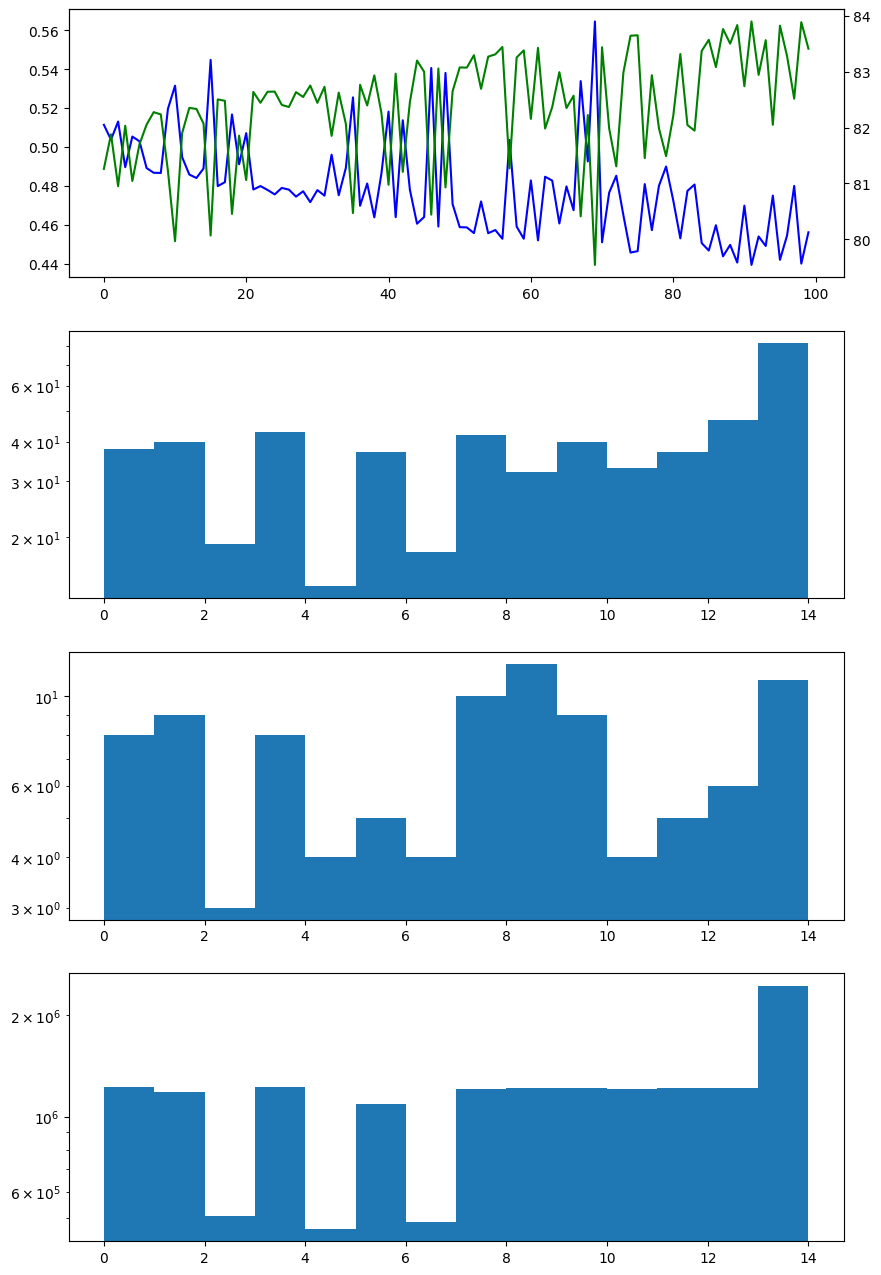

Final accuracy: 83.40833816687946%


In [ ]:
from matplotlib.pyplot import plot
import collections.abc

epochs = []
losses = []
tests = []

batch_size = 1000


for epoch in range(300): # 1000

    batch_test = []
    batch_loss = []

    for batch in range(0, input_train.shape[0], batch_size):
        labels = torch.squeeze(bin_output_train[batch:batch+batch_size].to(device))

        optimizer.zero_grad()
        outputs = latencyPred(input_train[batch:batch+batch_size].to(device))
        #print(outputs.shape)
        with torch.no_grad():
            _, predictions = torch.max(outputs.data, 1)
            predictions.to(device)
            #print("Number of predicted classes: ", len(np.unique(predictions)))
            num_correct = (predictions.to("cpu") == labels.to("cpu")).sum().item()

            batch_test.append(num_correct / outputs.shape[0] * 100)
            correct_dist_idx = (predictions == labels)

        loss = criterion(outputs, labels)
        batch_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    labels = torch.squeeze(bin_output_test)
    outputs = latencyPred(input_test)
    _, predictions = torch.max(outputs.data, 1)
    predictions.to(device)
    num_correct = (predictions.to("cpu") == labels.to("cpu")).sum().item()
    test_acc = num_correct / outputs.shape[0] * 100

    loss = criterion(outputs, labels)

    epochs.append(epoch)
    losses.append(loss.item())
    tests.append(test_acc)
    
    plot_loss(epochs, losses, tests, epoch==num_epoch-1)

    print('epoch {}, loss {}'.format(epoch, losses[-1]))
    print('correct predictions {}'.format(tests[-1]))

plot_all(epochs, losses, tests, correct_dist_idx, labels)
np.save("saved/pred", predictions.cpu())
np.save("saved/label", labels.cpu())

torch.save(latencyPred.state_dict(), "saved/model.pt")

print(f"Final accuracy: {tests[-1]}%")
if do_binary_classification and tests[-1] > naive_pred:
    print(f"We do a lil bit of learning, {tests[-1] - naive_pred}")

In [27]:
output_predictions = latencyPred(input_test)
soft_predictions = scipy.special.softmax(output_predictions.cpu().detach().numpy(), axis=1)

In [28]:
bin_predictions = [sum(i * value for i, value in enumerate(array)) for array in soft_predictions]
bin_predictions = np.array(bin_predictions).astype(int)

In [29]:
diffs = abs(bin_predictions - bin_output_test.cpu().detach().numpy().T)

In [31]:
# 4-feature model using 33% to test from all workloads
print(np.mean(diffs))
print(np.mean(diffs**2))
print(np.sqrt(np.mean(diffs**2)))
print(np.mean(diffs == 0))

0.6683818696238896
1.4212972736515548
1.1921817284506397
0.5209042382981705


In [27]:
latencyPred.eval()
latencyPred(torch.DoubleTensor(norm_input))

tensor([[ -6.5799,   3.9366,   4.4724,  ...,  -3.0395,  -4.5864, -14.2996],
        [-12.3283,  -2.6147,   5.0100,  ...,  -2.8761,  -4.0050, -17.3142],
        [ -6.3046,   1.4700,   4.2468,  ...,  -4.3976,  -4.5011, -16.6058],
        ...,
        [ -2.3788,  -1.9821,   2.4508,  ...,  -4.6448,  -6.0121, -19.0162],
        [-11.1532,  -7.3834,   1.0462,  ...,  -5.0560,  -5.1637, -15.9855],
        [ -2.3788,  -1.9821,   2.4508,  ...,  -4.6448,  -6.0121, -19.0162]],
       dtype=torch.float64, grad_fn=<AddmmBackward0>)

In [28]:
import pandas as pd

def layers_to_csv(layer, num):
    w_np = layer.cpu().state_dict()['weight'].numpy()
    b_np = layer.cpu().state_dict()['bias'].numpy()
    df = pd.DataFrame(w_np) #convert to a dataframe
    df.to_csv(index=False, header=False, sep=" ", path_or_buf=f"torch_model_new/linear{num}_w.csv", float_format="%015.6f") #save to file
    df = pd.DataFrame(b_np) #convert to a dataframe
    df.to_csv(index=False, header=False, sep=" ", path_or_buf=f"torch_model_new/linear{num}_b.csv", float_format="%015.6f")

In [29]:
layers_to_csv(latencyPred.module.layer_1, 0)
layers_to_csv(latencyPred.module.layer_2, 1)
layers_to_csv(latencyPred.module.layer_3, 2)
layers_to_csv(latencyPred.module.layer_out, 3)